# Data Wrangling Project

### Research Question:
- **What is the impact of PM 2.5 on premature deaths in Milan, Italy?**

#### Sub questions
- What is the impact of the polluants - NO2, O3, PM 2.5 - on premature deaths in Sassari (Sardegna, Italy) and Milan (Lombardy, Italy)? And how do the two cities compare?
- What is the impact of other particles like N02 and O3 compared to PM 2.5 ?
- How does Milan level of PM 2.5 and its impact on pollution compare to other major European cities?

In [92]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#### Cleaning and Pre-Processing of data

In [93]:
# read in Milan data - polluants: N02, O3, PM 2.5 between 2005 and 2021
df_milan = pd.read_csv("data_sets/milan.csv").dropna()
df_milan = df_milan.drop(columns=["City Boundary Specification (LAU/grid)", 'Country Or Territory', 'City', 'City Code', 'Health Risk Scenario', 'Premature Deaths - lower CI', 'Premature Deaths - upper CI', 'Years Of Life Lost', 'Years Of Life Lost - lower CI', 'Years Of Life Lost - upper CI'])

# read in Sassari data - polluants: N02, O3, PM 2.5 between 2005 and 2021
df_sassari = pd.read_csv("data_sets/sassari.csv").dropna()
df_sassari = df_sassari.drop(columns=["City Boundary Specification (LAU/grid)", 'Country Or Territory', 'City', 'City Code', 'Health Risk Scenario', 'Premature Deaths - lower CI', 'Premature Deaths - upper CI', 'Years Of Life Lost', 'Years Of Life Lost - lower CI', 'Years Of Life Lost - upper CI'])

# read in in Italian deaths attributed to PM 2.5 between 2005 and 2021
data_italy = pd.read_csv("data_sets/Italy_deaths_pm25.csv")
data_italy_filt = data_italy.drop(['Country Or Territory', 'Degree Of Urbanisation',
        'Air Pollutant', 'Health Risk Scenario', 'Population',
        'Populated Area [km2]', 'Air Pollution Average [ug/m3]',
        'Air Pollution Population Weighted Average [ug/m3]',
        'Premature Deaths - lower CI', 'Premature Deaths - upper CI',
        'Years Of Life Lost', 'Years Of Life Lost - lower CI',
        'Years Of Life Lost - upper CI'], axis=1)

# main European cities PM 2.5 levels and impact on premature death between 2005 and 2021
eur_cities = ["milan", "berlin", "paris", "warsaw", "amsterdam", "dublin", "ljubljana", "stockholm", "zagreb", "helsinki"]
eur_cities_df = []
for city in eur_cities:
    df_city = pd.read_csv(f"data_sets/europe_cities_pm25/{city}.csv")
    df_city = df_city.drop(columns=["City Boundary Specification (LAU/grid)", 'Country Or Territory', 'City Code', 'Health Risk Scenario', "Air Pollution Average [ug/m3]", 'Premature Deaths - lower CI', 'Premature Deaths - upper CI', 'Years Of Life Lost', 'Years Of Life Lost - lower CI', 'Years Of Life Lost - upper CI'])
    df_city['City'] = city
    eur_cities_df.append(df_city)
eur_cities = pd.concat(eur_cities_df, ignore_index=True)

### Data Transformation and Visualizations

In [94]:

def graph_prem_deaths_city(data_frame_group_year, pollutants, city):
    """
    Generates a bar graph visualizing the trends in air pollution and associated premature deaths in a given city.
    
    This function creates a subplot for each pollutant specified, displaying two sets of bars: 
    - one for the population-weighted average of air pollution
    - one for premature deaths attributed to that pollutant.
    """
    
    plt.figure(figsize=(16, 8))

    bar_width = 0.35

    for i, pollutant in enumerate(pollutants, 1):
        if i <= 2: 
            plt.subplot(2, 2, i)
        else: 
            plt.subplot(2, 2, i)

        subset = data_frame_group_year.loc[pollutant]
        index = range(len(subset.index))  # Create a list of indices for bar placement

        # Plotting
        plt.bar(index, subset['Air Pollution Population Weighted Average [ug/m3]'], 
                width=bar_width, label='Air Pollution')

        plt.bar([x + bar_width for x in index], subset['Premature Deaths'], 
                width=bar_width, label='Premature Deaths', color='orange')

        plt.title(f'Trends for {pollutant} {city}')
        plt.xlabel('Year')
        plt.xticks([x + bar_width / 2 for x in index], subset.index)
        plt.ylabel('Values')
        plt.legend()
    
    plt.tight_layout()

Impact of NO2, O3, and PM 2.5 on premature deaths in Milan, Lombardy, Italy

Mean Premature Deaths due to PM2.5 in Milan in 2005: 5318.0
Mean Premature Deaths due to PM2.5 in Milan in 2021: 3523.0


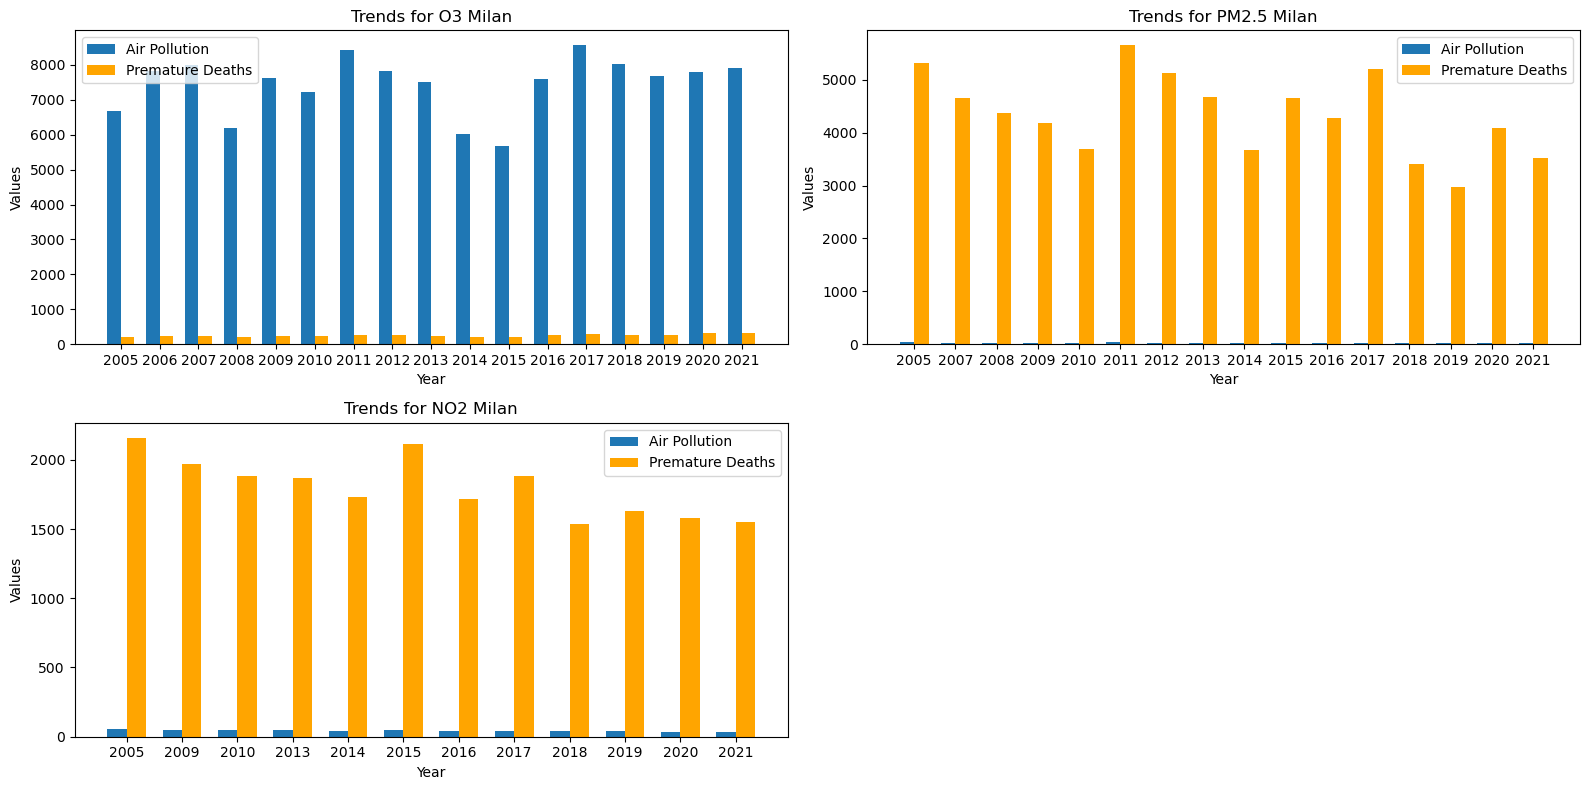

In [95]:
milan_group_polluant_year = df_milan.groupby(["Air Pollutant", 'Year'])[["Air Pollution Population Weighted Average [ug/m3]", "Premature Deaths"]].mean()
pollutants_milan = df_milan['Air Pollutant'].unique()
n_pollutants_milan = len(pollutants_milan)
graph_prem_deaths_city(milan_group_polluant_year, pollutants=pollutants_milan, city="Milan")

# Filter the Milan dataset to get data for the year 2005 and pollutant PM2.5
df_milan_2005_pm25 = df_milan[(df_milan['Year'] == 2005) & (df_milan['Air Pollutant'] == 'PM2.5')]
mean_premature_deaths_2005_pm25 = df_milan_2005_pm25['Premature Deaths'].mean()
print(f"Mean Premature Deaths due to PM2.5 in Milan in 2005: {mean_premature_deaths_2005_pm25}")

df_milan_2021_pm25 = df_milan[(df_milan['Year'] == 2021) & (df_milan['Air Pollutant'] == 'PM2.5')]
mean_premature_deaths_2021_pm25 = df_milan_2021_pm25['Premature Deaths'].mean()
print(f"Mean Premature Deaths due to PM2.5 in Milan in 2021: {mean_premature_deaths_2021_pm25}")

Impact of NO2, O3, and PM 2.5 on premature deaths in Sassary, Sardegna, Italy

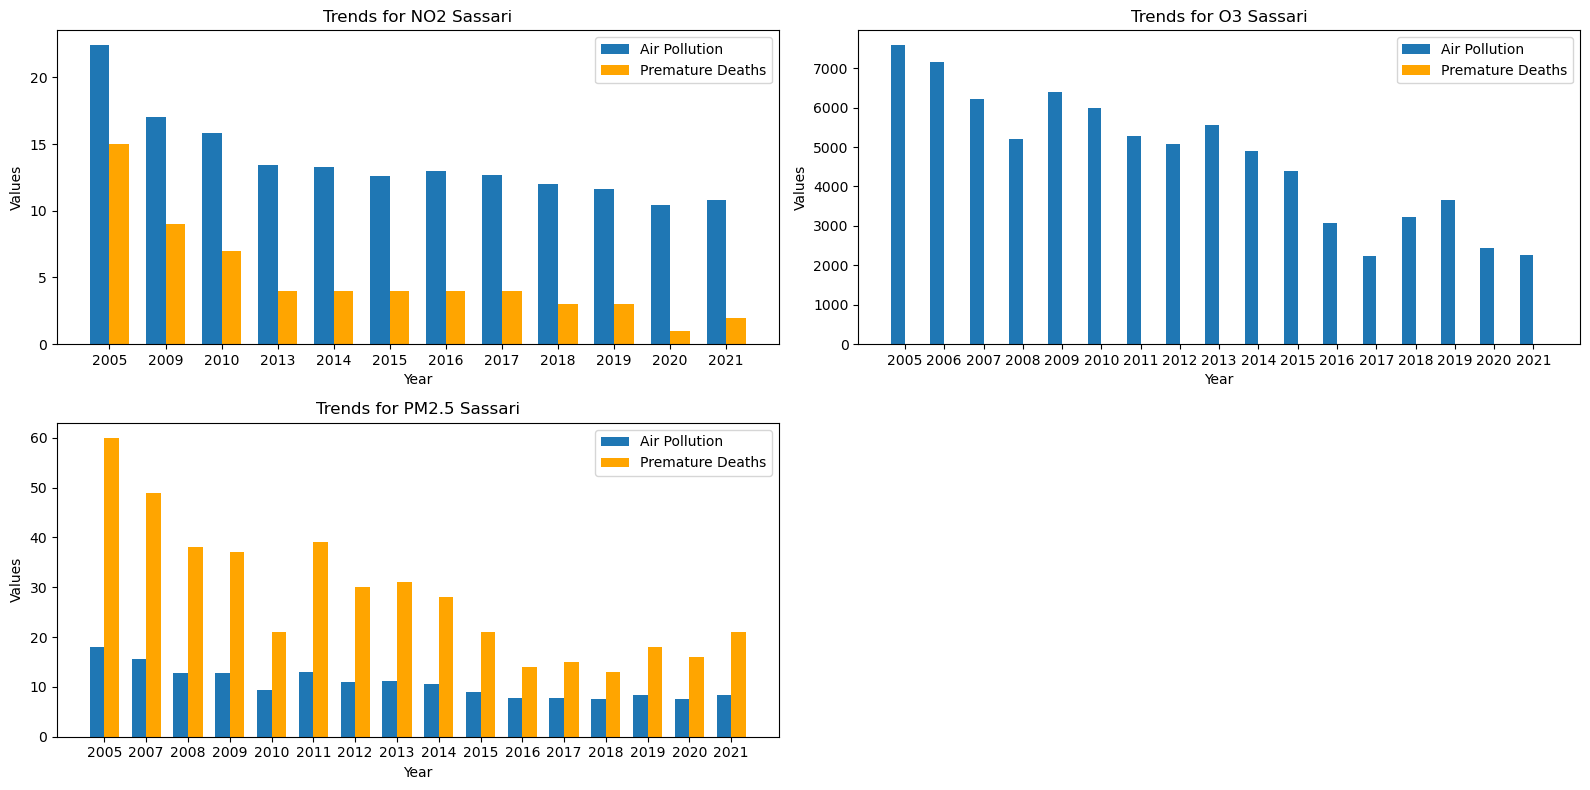

In [86]:
sassari_group_polluant_year = df_sassari.groupby(["Air Pollutant", 'Year'])[["Air Pollution Population Weighted Average [ug/m3]", "Premature Deaths"]].mean()
pollutants_sassari = df_sassari['Air Pollutant'].unique()
n_pollutants_sassari = len(pollutants_sassari)
graph_prem_deaths_city(sassari_group_polluant_year, pollutants=pollutants_sassari, city="Sassari")

#### Linear Regression for Milan and Sassari

In [87]:
def linear_reg(df_city, pollutants, city, n_pollutants=3):
    """
    This function performs a linear regression on air pollution data for a given city and visualizes the relationship 
    between air pollution levels and premature deaths for specified pollutants.
    It also gives some statistical results from the linear regression
    """
    
    plt.figure(figsize=(10, 4 * n_pollutants))
    for i, pollutant in enumerate(pollutants, 1):
        if i <= 2: 
            plt.subplot(2, 2, i)
        else: 
            plt.subplot(2, 2, i)
        
        # Filter for the current pollutant
        pollutant_data = df_city[df_city['Air Pollutant'] == pollutant][['Year', 'Air Pollution Population Weighted Average [ug/m3]', 'Premature Deaths']]
        X = pollutant_data[['Air Pollution Population Weighted Average [ug/m3]']]
        y = pollutant_data['Premature Deaths']

        # Perform linear regression
        model = LinearRegression()
        model.fit(X, y)
        predictions = model.predict(X)
        
        # analysis results for the current pollutant
        print(f"Pollutant: {pollutant}")
        print("Coefficients:", model.coef_)
        print("Intercept:", model.intercept_)
        print("R-squared:", model.score(X, y))
        print("Mean Squared Error:", mean_squared_error(y, predictions))
        print("\n")
        
        # Plotting the data and Linear Regression
        plt.scatter(X, y, label='Actual Data', color='blue')
        plt.plot(X, predictions, label='Linear Regression', color='red')
        plt.title(f'Linear Regression: {pollutant} vs. Premature Deaths in {city}')
        plt.xlabel(f'{pollutant} Air Pollution Population Weighted Average [ug/m3]')
        plt.ylabel('Premature Deaths')
        plt.legend()
        plt.tight_layout()

Pollutant: O3
Coefficients: [0.03744938]
Intercept: -31.98005039628154
R-squared: 0.6708633135996678
Mean Squared Error: 440.0659996486545


Pollutant: PM2.5
Coefficients: [140.41159026]
Intercept: 547.8065558991243
R-squared: 0.8928671420752513
Mean Squared Error: 58424.37468228799


Pollutant: NO2
Coefficients: [32.31866321]
Intercept: 407.0330158576287
R-squared: 0.8750524412603685
Mean Squared Error: 5128.377970107739




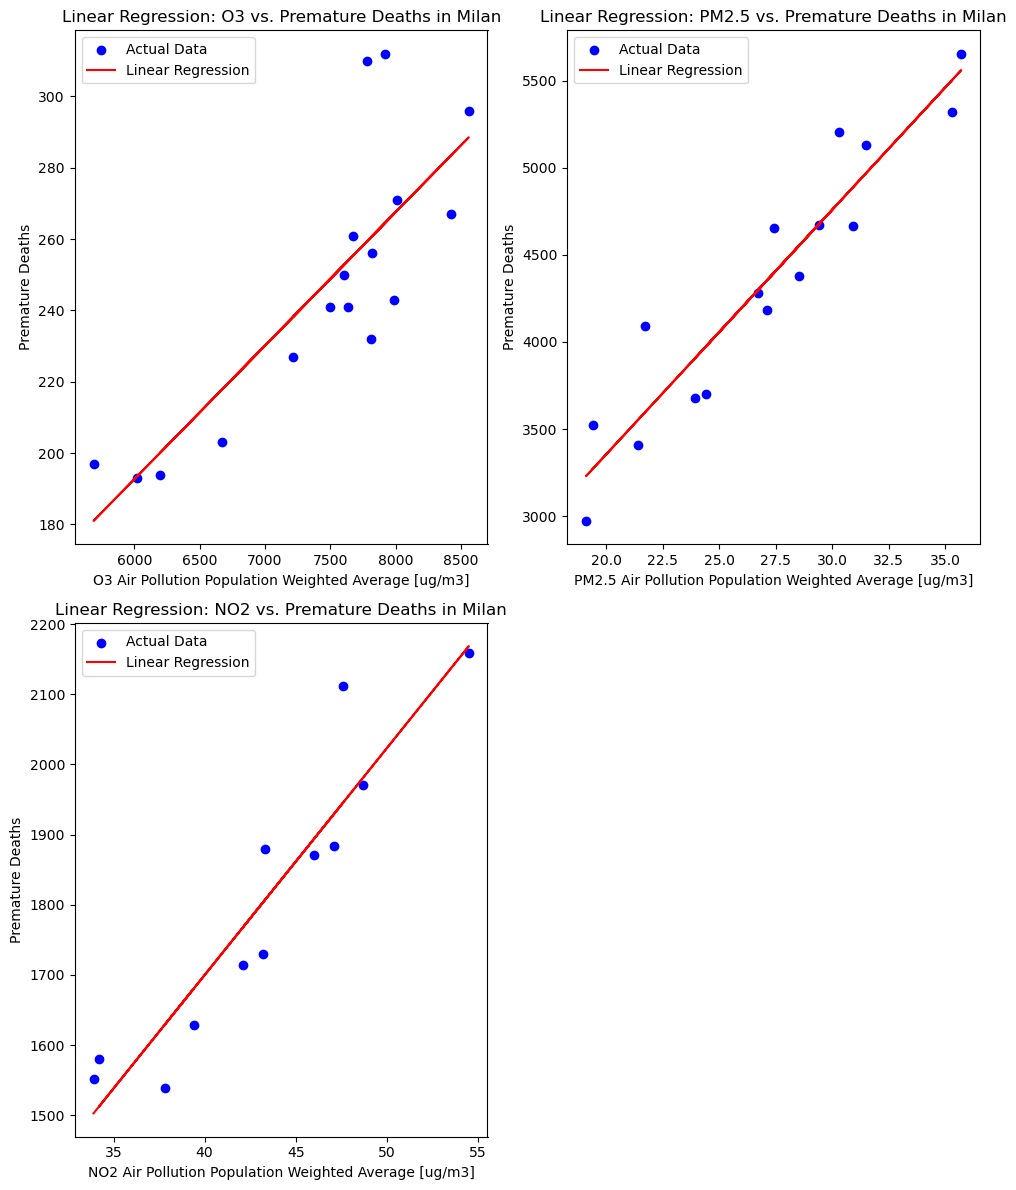

In [88]:
# Linear reg for Milan
linear_reg(df_milan, pollutants=pollutants_milan, city="Milan", n_pollutants=n_pollutants_milan)

Pollutant: NO2
Coefficients: [1.14015434]
Intercept: -10.677122230520286
R-squared: 0.991501309308855
Mean Squared Error: 0.11189942743340799


Pollutant: O3
Coefficients: [0.000721]
Intercept: 0.3439356634754791
R-squared: 0.9489520439093541
Mean Squared Error: 0.0752471601889799


Pollutant: PM2.5
Coefficients: [4.34179741]
Intercept: -18.05264244426092
R-squared: 0.9923996024123614
Mean Squared Error: 1.3112764072391947




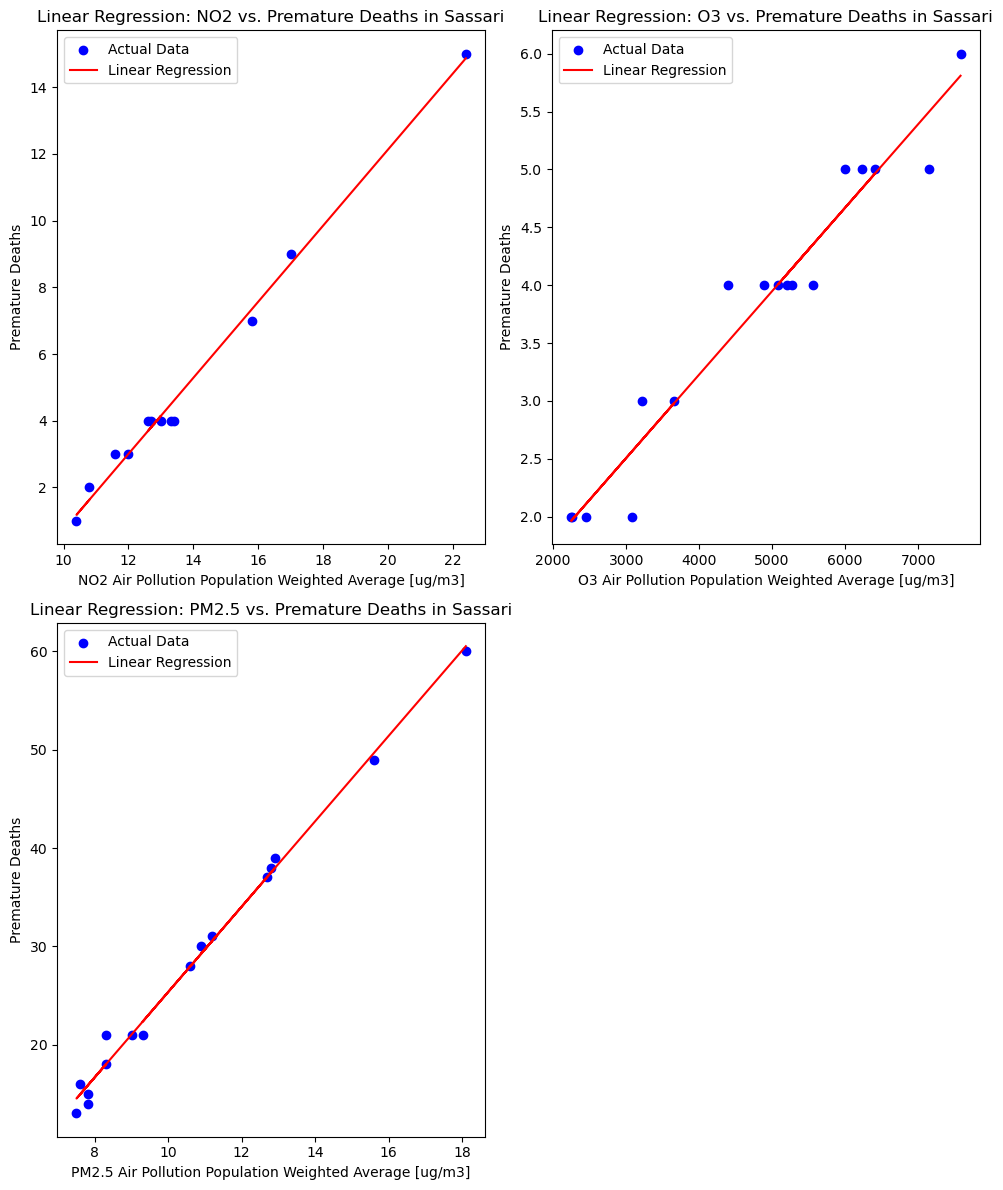

In [89]:
# Linear reg for Sassari
linear_reg(df_sassari, pollutants=pollutants_sassari, city="Sassari", n_pollutants=n_pollutants_sassari, )

# Italy and Milan death rate due to PM 2.5

Average impact of Milan on the total premature deaths in Italy is: 7.85%


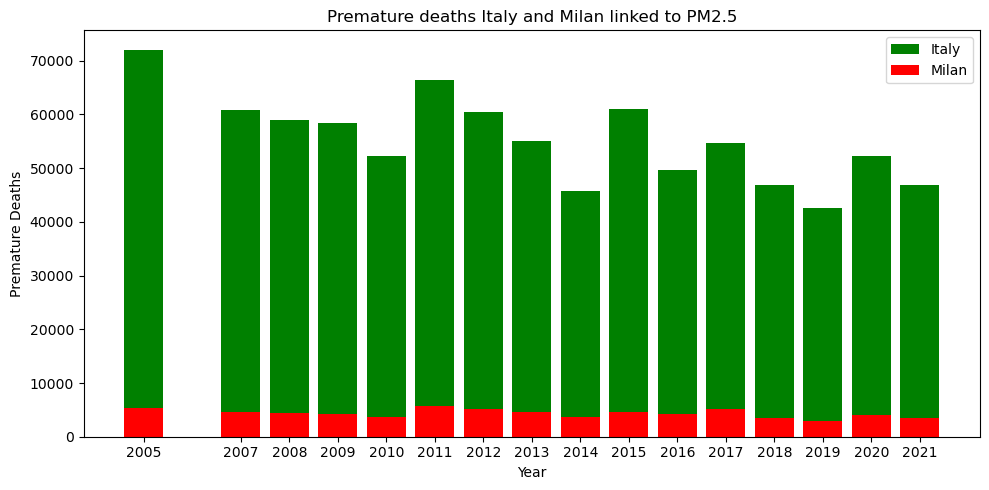

In [90]:
# Read PM2.5 related deaths data for Italy
pm25_deaths_it = pd.read_csv("cleaned_data/italy_deaths_pm25.csv")
pm25_deaths_italy = pd.DataFrame(pm25_deaths_it)
pm25_deaths_italy.rename(columns={"Premature Deaths": "Premature Deaths Italy"}, inplace=True)

# Filter Milan data for PM2.5 pollutant
df_milan_pm25 = df_milan[df_milan['Air Pollutant'] == 'PM2.5'].copy()
df_milan_pm25.rename(columns={"Premature Deaths": "Premature Deaths Milan"}, inplace=True)
df_milan_pm25 = df_milan_pm25.drop(columns=['Total City Population *', 'Air Pollutant', 'Populated Area [km2]', 'Air Pollution Average [ug/m3]', 'Air Pollution Population Weighted Average [ug/m3]'])

# Merge Italy and Milan data to analyze them together
deaths_pm25 = pm25_deaths_italy.merge(df_milan_pm25, how='outer')

# Calculate the percentage impact of Milan's premature deaths on Italy's total
milan_impact_ital_percentage = [row["Premature Deaths Milan"]/row["Premature Deaths Italy"]*100 for _, row in deaths_pm25.iterrows()]
average_percentage_impact = sum(milan_impact_ital_percentage) / len(milan_impact_ital_percentage)
print(f"Average impact of Milan on the total premature deaths in Italy is: {round(average_percentage_impact, 2)}%")

# Graphing bar plot of the comparions of premature deaths in Milan and Italy
plt.figure(figsize=(10, 5))
plt.bar(deaths_pm25['Year'], deaths_pm25['Premature Deaths Italy'], label='Italy', color='green' )
plt.bar(deaths_pm25['Year'], deaths_pm25['Premature Deaths Milan'], label='Milan', color='red' )
plt.title('Premature deaths Italy and Milan linked to PM2.5')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Premature Deaths')
plt.tight_layout()
plt.xticks(deaths_pm25['Year'])
plt.show()

### Milan and other main european cities - Premature deaths VS PM2.5 levels of polution

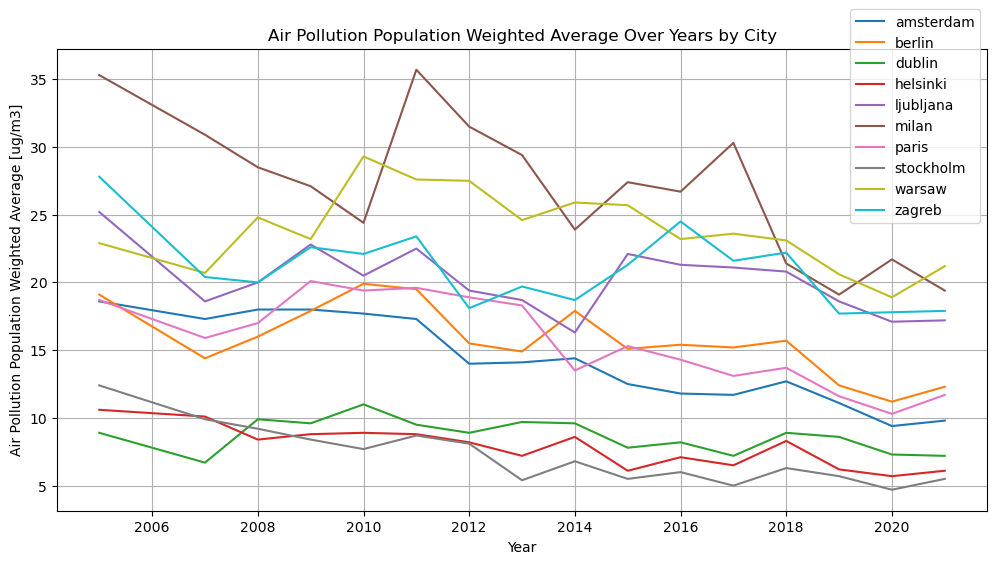

In [91]:
# Load and pivot the data for the main European cities - for PM 2.5 pollution
eur_city_pm25 = pd.read_csv("cleaned_data/merged_european_cities_data.csv")
eur_city_pm25_pivot = eur_city_pm25.pivot(index='Year', columns='City', values='Air Pollution Population Weighted Average [ug/m3]')

# Plotting
plt.figure(figsize=(12, 6))
for city in eur_city_pm25_pivot.columns:
    plt.plot(eur_city_pm25_pivot.index, eur_city_pm25_pivot[city], label=city)

plt.xlabel('Year')
plt.ylabel('Air Pollution Population Weighted Average [ug/m3]')
plt.title('Air Pollution Population Weighted Average Over Years by City')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.1))
plt.grid(True)